In [192]:
import pandas as pd
from playwright.async_api import async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless = False)
page = await browser.new_page()
from tqdm.notebook import tqdm
import time
import pdb
import csv
from PIL import Image
import requests
import pytesseract

In [193]:
url = 'https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b'

In [195]:
await page.goto(url)

<Response url='https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b' request=<Request url='https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b' method='GET'>>

In [196]:
await page.locator('.alert-danger-cust').get_by_text('Select state, district and court complex to proceed further', exact=True).wait_for()
await page.locator('//*[@id="validateError"]/div/div/div[1]/button').click()

In [197]:
await page.locator('#sess_state_code').select_option('1')

['1']

In [198]:
await page.locator('#sess_dist_code').select_option('9')

['9']

### 'Nagpur, District Sessions Court III' and 'Nagpur District Sessions Court' are two district courts in Nagpur district

In [199]:
#Nagpur, District Sessions Court III
await page.locator('#court_complex_code').select_option('1010122@1,3,4,5,8@N')
#Nagpur District Sessions Court
#await page.locator('#court_complex_code').select_option('1010123@2@N')

['1010122@1,3,4,5,8@N']

In [200]:
await page.locator('//*[@id="act-tabMenu"]').click()

In [201]:
await page.locator('#actcode').select_option('1')

['1']

In [202]:
await page.locator('#under_sec').fill('302')

In [203]:
await page.locator('#radPAct').click()

In [204]:
captcha_image = await page.locator('#div_captcha_act #captcha_image').screenshot(type='png')

with open('captcha.png', 'wb') as fp:
    print("Saved as captcha.png")
    fp.write(captcha_image)

Saved as captcha.png


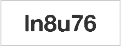

In [205]:
image = Image.open('captcha.png')
image

In [206]:
answer = pytesseract.image_to_string(image).strip()
answer

'In8u76'

In [207]:
await page.locator('#act_captcha_code').fill(answer)

In [208]:
await page.locator('//*[@id="frm_act"]/div[3]/div[2]/button').click()

In [209]:
table_1 = await page.query_selector_all('tr')

for row in table_1:
    print(await row.text_content())

In [210]:
# headers = ['case_id', 'case_title', 'court_name', ' Case Type', ' Filing Number ',
#        'Registration Number', 'CNR Number', 'First Hearing Date',
#        'Next Hearing Date', 'Case Stage', 'News and Events and Judge', 'Court Number and Judge',
#        'Court Number and Name', 'Case Number and Year', 'Case Decision Date',
#        'Police Station', 'FIR Number', 'Year', 'petitioner_and_advocate',
#        'respondent_and_advocate','Case Transferred from Establishment', 'Case Transferred to Establishment', 'Transfer Date']

# with open('NAGPUR_pending_case_data.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile) # define a writer
#     writer.writerow(headers) # write the row

In [211]:
# async def view_button_click_and_close_error_message(row):
#     view_button = await row.query_selector('a')
#     await view_button.click()
# #     print('clicked view button')
#     error_button = await page.query_selector('//*[@id="validateError"]/div/div/div[1]/button')
#     if error_button.is_visible():
#         await error_button.click()
# #         print('found error button')
#         raise Exception('error after clicking view')

# Function_1 scrape_weird_first_table()

In [130]:
async def scrape_weird_first_table(table):
    case_detail_table = {}
    all_trs = await table.query_selector_all('tr')
    for tr in all_trs:
        key_element = await tr.query_selector_all('td')
        key = await key_element[0].text_content()
        value_element = await tr.query_selector_all('td')
        value = await value_element[1].text_content()
        case_detail_table[key] = value
    return case_detail_table

# Function_2 scrape_side_by_side_table()

In [131]:
async def scrape_side_by_side_table(table):
    case_status_table = {}
    all_trs = await table.query_selector_all('tr')
    for tr in all_trs:
        all_tds = await tr.query_selector_all('td')
        if len(all_tds) == 2:
            left_column = await tr.query_selector_all('td')
            keys = await left_column[0].text_content()
            right_column = await tr.query_selector_all('td')
            values = await right_column[1].text_content()
            case_status_table[keys] = values
        else:
            pass
    return case_status_table

# Function_3 scrape_dataframe_style_table()

In [132]:
async def scrape_dataframe_style_table(table):
    tables = pd.read_html(await page.content())
    return tables[5]

# Scraping (Petitioner + Respondent) & Advocates

## petitioner_and_advocate_table
#### Save all tds in form of a list and add the list as value to the result dictionary
#### This will take care of pages where there are multiple tds which means multiple petitioners

In [133]:
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
# petitioner_advocate = {}
# petitioner_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         petitioner_and_advocate.append(await td.text_content())
#         petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
#     print(petitioner_advocate)          

## respondent_and_advocate_table
#### Save all tds in form of a list and add the list as value to the result dictionary
#### This will take care of pages where there are multiple tds which means multiple respondents

In [134]:
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# all_trs = await respondent_and_advocate_table.query_selector_all('tr')
# respondent_advocate = {}
# respondent_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         respondent_and_advocate.append(await td.text_content())
#         respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
#     print(respondent_advocate)     

In [216]:
table_1 = await page.query_selector_all('tr')
index=0


for row in tqdm(table_1[1:]):
    index = index + 1
    list_of_cases = []
    each_case = {}
    all_tds = await row.query_selector_all('td')
    if len(all_tds) == 2:
        court_name = await all_tds[0].text_content()
    elif len(all_tds) == 4:
        case_id = await row.query_selector('td:nth-child(2)')
        case_title = await row.query_selector('td:nth-child(3)')
        each_case['case_id'] = (await case_id.text_content())
        each_case['case_title'] = (await case_title.text_content())
        each_case['court_name'] = court_name
    
        ###########################
        # if index==15:
        #    break # for debugging, delete later
        ###########################    

        already_scraped_df = pd.read_csv('NAGPUR_pending_case_data.csv')
        already_scraped_case_ids = list(already_scraped_df['case_id'])
        if each_case['case_id'] in already_scraped_case_ids:
#             print(f"Already scraped {each_case['case_id']}")
            continue # this means go back to the top of the loop without finishing this iteration
        
        print(f"Scraping {each_case['case_id']}")
            
        time.sleep(3)
        
        
        #Because this case's view button acts weird, we are skipping this case
        cases_to_skip = ['R.C.C./300630/2015', 'Sessions Case/228/2018', 'Sessions Case/100213/2014']
        if each_case['case_id'] in cases_to_skip:
            with open('pending_case_data.csv', 'a') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=headers)
                writer.writerow(each_case)
            list_of_cases.append(each_case)
            continue
            
        #Click on view button
        view_button = await row.query_selector('a')
        await view_button.click()
            
        time.sleep(5)

        #Scrape the view contents and put them in each_case

        #case_details
        case_details_table = await page.query_selector('#CSact .case_details_table')
        case_details = await scrape_weird_first_table(case_details_table)
            #print(case_details)

        #case_status
        cases_status_table = await page.query_selector('#CSact .case_status_table')
        cases_status = await scrape_side_by_side_table(cases_status_table)
            #print(cases_status)

        #subordinate court
        lower_court_table = await page.query_selector('#CSact .Lower_court_table')
        if lower_court_table:
            lower_court = await scrape_side_by_side_table(lower_court_table)
        else:
            print("Failed to scrape lower court table")
            #print(lower_court)

        #FIR_details
        FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
        if FIR_details_table:
            FIR_details = await scrape_side_by_side_table(FIR_details_table)
        else:
            FIR_details = {}
            print("Failed to scrape FIR details table")
            #Put the result through pd.DataFrame() after looping
            #print(FIR_details)

        #petitioner_advocate
        petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
        all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
        petitioner_advocate = {}
        petitioner_and_advocate = []
        for tr in all_trs:
            all_tds = await tr.query_selector_all('td')
            for td in all_tds:
                petitioner_and_advocate.append(await td.text_content())
                petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
                #print(petitioner_advocate)

        #respondent_advocate
        respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
        all_trs = await respondent_and_advocate_table.query_selector_all('tr')
        respondent_advocate = {}
        respondent_and_advocate = []
        for tr in all_trs:
            all_tds = await tr.query_selector_all('td')
            for td in all_tds:
                respondent_and_advocate.append(await td.text_content())
                respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
                #print(respondent_advocate)

        #click back button
        back_button = page.locator('#main_back_act')
        await back_button.click()
        
        time.sleep(5)
        
        all_case_data = {**each_case, **case_details, **cases_status, **lower_court, **FIR_details, **petitioner_advocate, **respondent_advocate}

        with open('NAGPUR_pending_case_data.csv', 'a') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=headers)
            writer.writerow(all_case_data)   
            
        list_of_cases.append(all_case_data)

    else:
        raise Exception("Error parsing table. Expected 2 or 4 td elements.")

  0%|          | 0/771 [00:00<?, ?it/s]

Scraping Sessions Case/228/2018
Scraping Sessions Case/100213/2014
Scraping Spl.Case/181/2020
Failed to scrape lower court table
Scraping Spl.Case/146/2020
Failed to scrape lower court table
Scraping Spl.Case/105/2020
Failed to scrape lower court table
Scraping Spl.Case/65/2020
Scraping Atro.Spl.Case/41/2019
Failed to scrape lower court table
Scraping Atro.Spl.Case/10/2019
Failed to scrape lower court table
Scraping Atro.Spl.Case/74/2018
Failed to scrape lower court table
Scraping Atro.Spl.Case/56/2018
Failed to scrape lower court table
Scraping Atro.Spl.Case/33/2018
Failed to scrape lower court table
Scraping Atro.Spl.Case/47/2017
Failed to scrape lower court table
Scraping Atro.Spl.Case/11/2016
Failed to scrape lower court table
Scraping Atro.Spl.Case/6/2016


CancelledError: 

In [214]:
data_so_far = pd.read_csv('NAGPUR_pending_case_data.csv')
data_so_far.to_csv(f'pending_case_data_{pd.Timestamp.now()}.csv')

## For Nagpur District Court

### The number of cases changed on the tqdm from 122 to 200 even though the number of cases on the page remained the same. 
### I got all 122 cases on the page but it is now trying to scrape 

## For Nagpur District Court III

### It is scraping 771 cases when there are only 703! 
### This also started again from around 100 cases before the end! 

In [ ]:
#df.to_csv('MAH_pending_302.csv', index=False)

In [ ]:
#pd.read_csv('MAH_pending_302.csv')

In [ ]:
#SAFEKEEPING

# view_button = await page.locator('//*[@id="dispTable"]/tbody/tr[2]/td[4]/a').click()
# #case_details
# case_details_table = await page.query_selector('#CSact .case_details_table')
# case_details = await scrape_weird_first_table(case_details_table)
# print(case_details)

# #case_status
# cases_status_table = await page.query_selector('#CSact .case_status_table')
# cases_status = await scrape_side_by_side_table(cases_status_table)
# print(cases_status)

# #subordinate court
# lower_court_table = await page.query_selector('#CSact .Lower_court_table')
# lower_court = await scrape_side_by_side_table(lower_court_table)
# print(lower_court)

# #FIR_details
# FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
# FIR_details = await scrape_side_by_side_table(FIR_details_table)
# #Put the result through pd.DataFrame() after looping
# print(FIR_details)

# #petitioner_advocate
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
# petitioner_advocate = {}
# petitioner_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         petitioner_and_advocate.append(await td.text_content())
#         petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
#     print(petitioner_advocate)
    
# #respondent_advocate
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# all_trs = await respondent_and_advocate_table.query_selector_all('tr')
# respondent_advocate = {}
# respondent_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         respondent_and_advocate.append(await td.text_content())
#         respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
#     print(respondent_advocate)

In [ ]:
#back_button = await page.locator('//*[@id="main_back_act"]').click()

In [ ]:
#List of tables for reference and mental health

# case_details_table = await page.query_selector('#CSact .case_details_table')
# cases_status_table = await page.query_selector('#CSact .case_status_table')
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# acts_table = await page.query_selector('#CSact .acts_table')
# lower_court_table = await page.query_selector('#CSact .Lower_court_table')
# FIR_details_table = await page.query_selector('#CSact .FIR_details_table')

In [ ]:
# collect dictionaries for each table
# case_details_data = scrape_weird_first_table(case_details_table)
# case_status_data = scrape_side_by_side_table(case_status_table)

# # combine dictionaries
# case_data = {**case_details_data, **case_status_data}

### case_details_table

In [ ]:
case_details_table = await page.query_selector('#CSact .case_details_table')
case_details = await scrape_weird_first_table(case_details_table)
print(case_details)

### cases_status_table

In [ ]:
cases_status_table = await page.query_selector('#CSact .case_status_table')
cases_status = await scrape_side_by_side_table(cases_status_table)
print(cases_status)

### lower_court_table

In [ ]:
lower_court_table = await page.query_selector('#CSact .Lower_court_table')
lower_court = await scrape_side_by_side_table(lower_court_table)
print(lower_court)

### FIR_details_table

In [ ]:
FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
FIR_details = await scrape_side_by_side_table(FIR_details_table)
#Put the result through pd.DataFrame() after looping
print(FIR_details)

### acts_table

In [ ]:
acts_table = await page.query_selector('#CSact .acts_table')
acts = await scrape_dataframe_style_table(acts_table)
print(acts)